In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 100:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./loo_fft_dense16.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label,plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
pretrainer = loadconceptor('../../../checkpoint/latest/pretrainer.pt')
data_path = '../../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfcx, _ = pretrainer.predict(dfcx, batch_size=16)
dfy = df_label.response_label

size = df_label.groupby('cohort').size()
size = size.index + "\n(n = " + size.astype(str) + ")"
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()
#cohorts = ['Choueiri']

100%|##########| 71/71 [00:03<00:00, 20.28it/s]


In [3]:
def leave_one_cohort_out(cohorts):
    # Create a list of lists, each missing one element from the original list
    return [(cohorts[i], cohorts[:i] + cohorts[i+1:]) for i in range(len(cohorts))]
train_test_cohorts = leave_one_cohort_out(cohorts)


In [4]:
from conceptor.decoder import ProtoNetNFTDecoder

scols = dfcx.columns
dfx_used = dfcx[scols]

mode = 'NFT'
seed = 42
work_dir = './LOCO_a100/LOCO_%s_%s' % (mode, seed)
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

(1117, 45)
(1116, 45)


posx and posy should be finite values


(1112, 45)


posx and posy should be finite values


(1108, 45)


posx and posy should be finite values
posx and posy should be finite values


(1108, 45)
(1107, 45)
(1099, 45)
(1094, 45)
(1088, 45)


posx and posy should be finite values
posx and posy should be finite values


(1082, 45)
(1060, 45)


posx and posy should be finite values


(1044, 45)


posx and posy should be finite values
posx and posy should be finite values


(1031, 45)


posx and posy should be finite values


(1026, 45)
(968, 45)
(835, 45)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


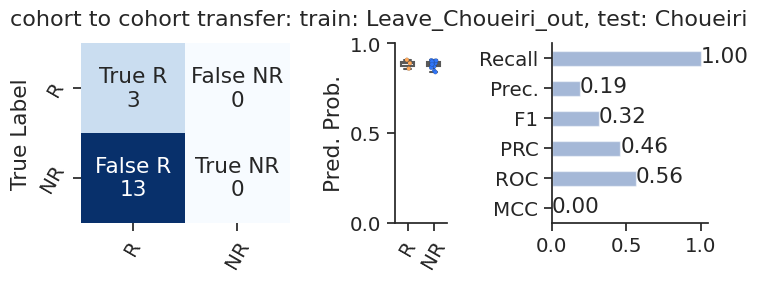

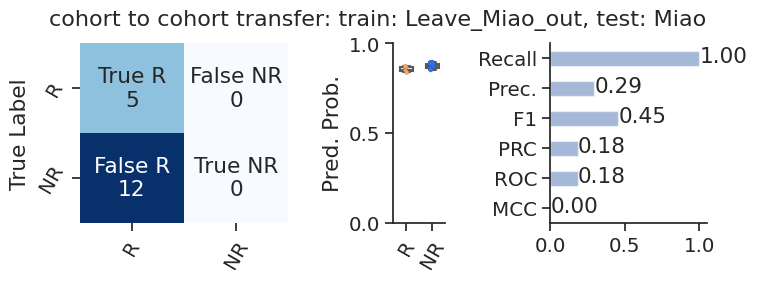

posx and posy should be finite values
posx and posy should be finite values


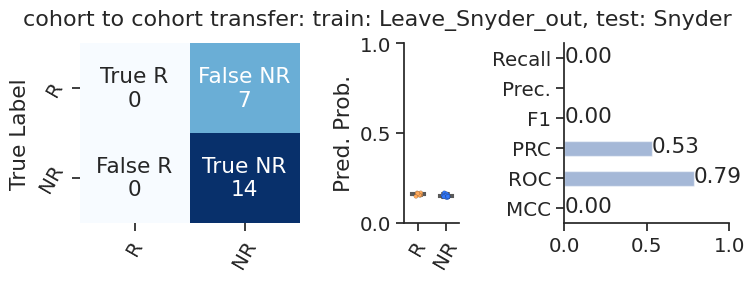

posx and posy should be finite values
posx and posy should be finite values


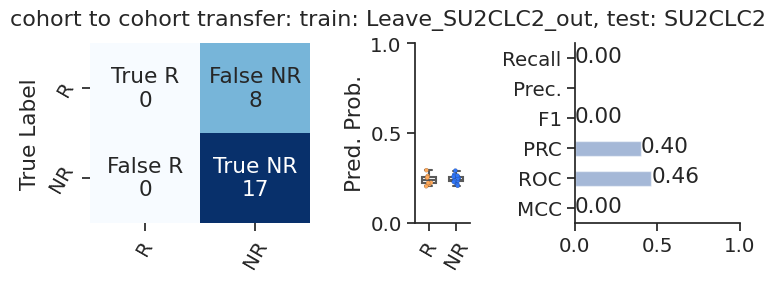

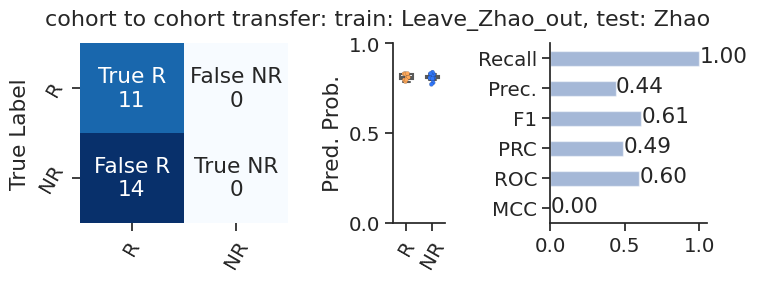

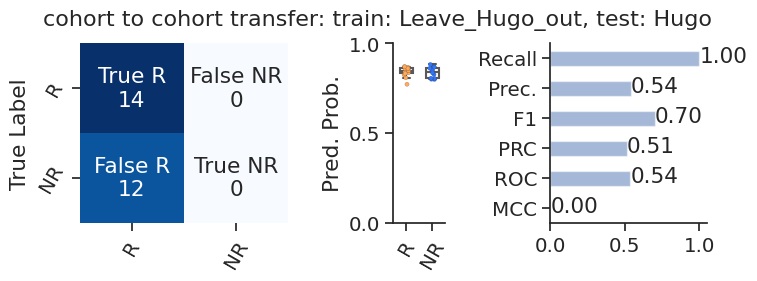

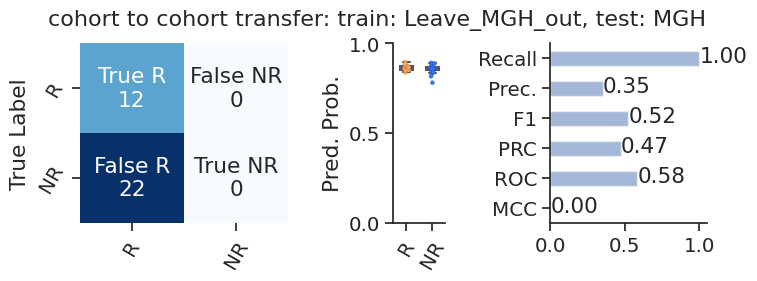

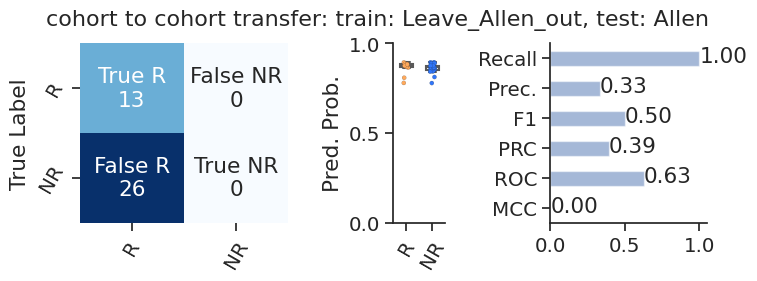

posx and posy should be finite values
posx and posy should be finite values


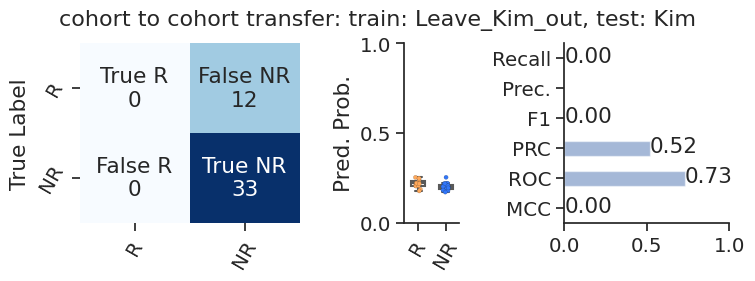

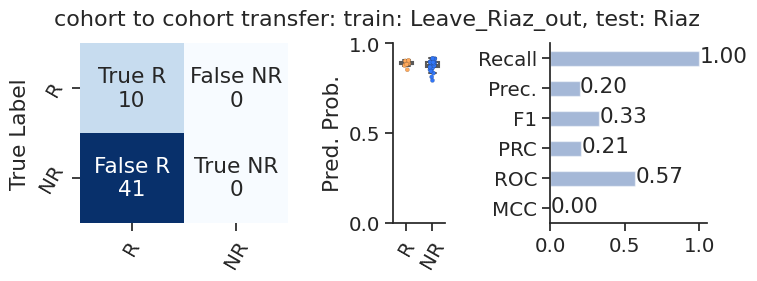

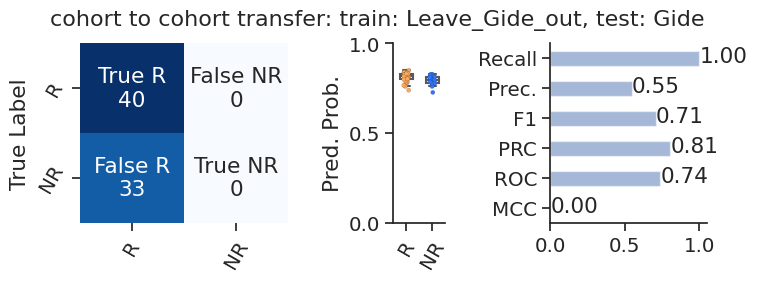

posx and posy should be finite values
posx and posy should be finite values


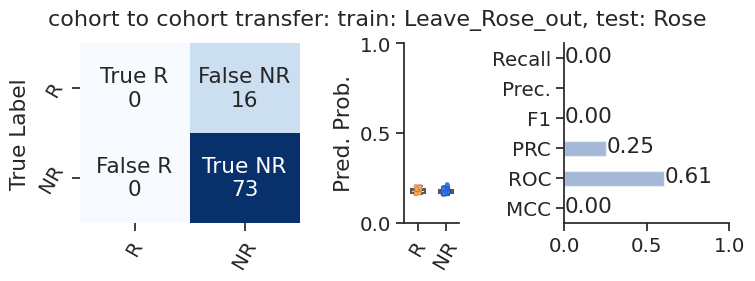

posx and posy should be finite values
posx and posy should be finite values


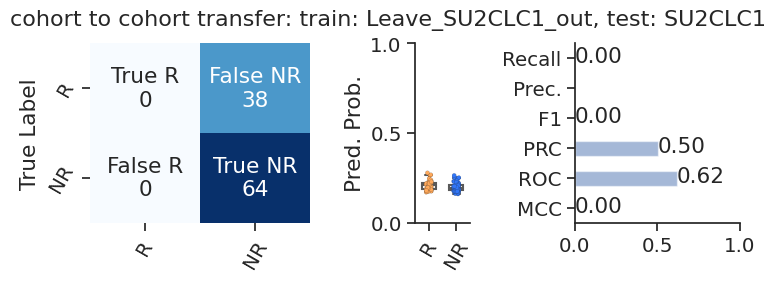

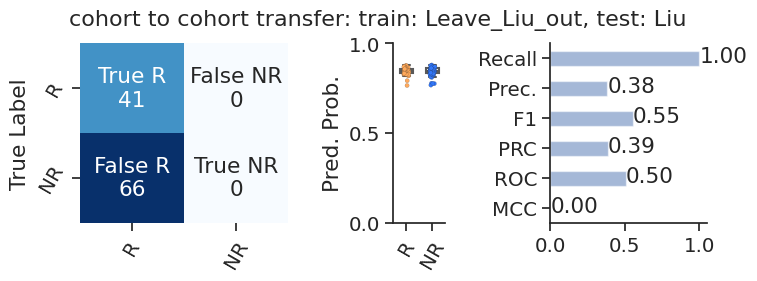

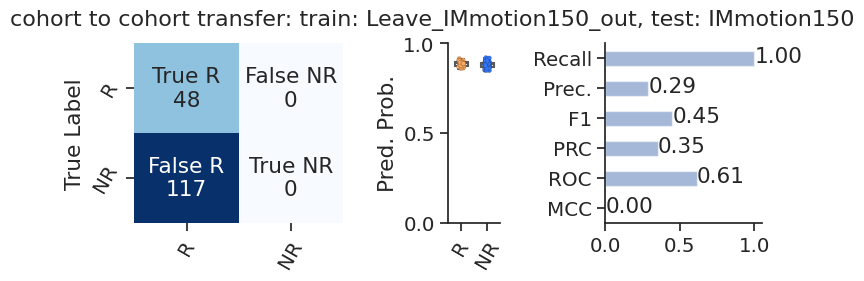

posx and posy should be finite values
posx and posy should be finite values


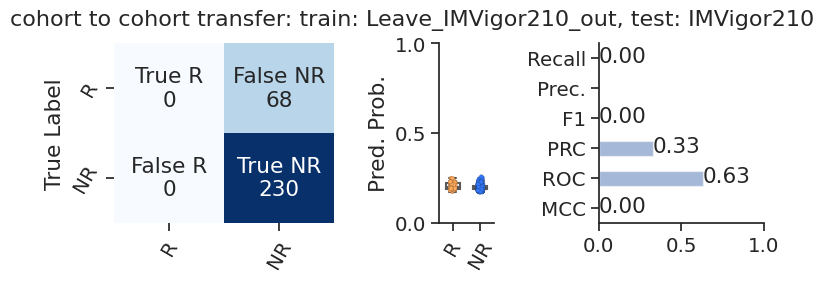

In [5]:
res = []
for test_cohort, train_cohorts in train_test_cohorts:

    train_cohort_name = 'Leave_%s_out' % test_cohort
    
    ## Get data for this cohort
    cohort_idx = df_label[df_label['cohort'].isin(train_cohorts)].index
    cohort_X = dfcx.loc[cohort_idx]
    cohort_y = dfy.loc[cohort_idx]

    
    ## Get features for specific method
    train_X = cohort_X
    train_y = cohort_y
    
    support_set = train_X.join(train_y)
    print(support_set.shape)
    
    NFT = ProtoNetNFTDecoder()
    NFT = NFT.fit(support_set)
    

    test_cohort_idx = df_label[df_label['cohort'] == test_cohort].index
    test_cohort_X = dfcx.loc[test_cohort_idx]
    test_cohort_y = dfy.loc[test_cohort_idx]

    query_set = test_cohort_X.join(test_cohort_y)
    pred_testy = NFT.transform(query_set)

    pred_testy['train_cohort'] = train_cohort_name
    pred_testy['test_cohort'] = test_cohort 
    
    pred_testy['best_epoch'] = 0
    pred_testy['n_trainable_params'] = 0
    pred_testy['mode'] = mode
    pred_testy['seed'] = seed
    pred_testy['batch_size'] = np.nan
    pred_testy['task_dense_layer'] = np.nan
    #dfp = test_cohort_y.join(pred_testy)

    dfp = onehot(test_cohort_y.map({'PD':'NR', 'PR':'R',
                               'SD':'NR', 'CR':'R',
                               'NR':'NR', 'R':'R'})).join(pred_testy)

    y_true, y_prob, y_pred = dfp['R'], dfp[1], dfp[[0, 1]].idxmax(axis=1)
    fig = plot_performance(y_true, y_prob, y_pred)
    fig.suptitle('cohort to cohort transfer: train: %s, test: %s' % (train_cohort_name, test_cohort), fontsize=16)
    fig.savefig(os.path.join(work_dir, 'CTCT_train_%s_test_%s.jpg' % (train_cohort_name, test_cohort)))
    res.append(dfp)

dfs = pd.concat(res)
dfp = dfs.groupby(['train_cohort', 'test_cohort']).apply(lambda x:score2(x['R'], x[1], x[[0, 1]].idxmax(axis=1)))


#roc, prc, f1, acc, mcc
dfp = dfp.apply(pd.Series)
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC', 'MCC']
dfp = dfp.reset_index()

dfs.to_csv(os.path.join(work_dir, 'source_performance.tsv'), sep='\t')
dfp.to_csv(os.path.join(work_dir, 'metric_performance.tsv'), sep='\t')
